In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

2022-07-29 20:44:01.451285: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-29 20:44:01.456190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-29 20:44:01.456209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)


Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [11]:
test_X = mnist.test.images
test_Y = mnist.test.labels
print(test_X.shape, test_Y.shape)

(10000, 784) (10000, 10)


In [9]:
validation_X = mnist.validation.images
validation_Y = mnist.validation.labels
print(validation_X.shape, validation_Y.shape)

(5000, 784) (5000, 10)


In [4]:
train_X = mnist.train.images
train_Y = mnist.train.labels
print(train_X.shape, train_Y.shape)

(55000, 784) (55000, 10)


In [5]:
print(train_X[0])  # 是一个包含784个元素且值在[0,1]之间的向量

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [7]:
print(train_Y[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


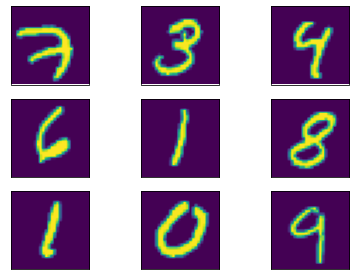

In [12]:
# 可视化样本，下面是输出了训练集中前4个样本
fig, ax = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(9):
    img = train_X[i].reshape(28, 28)
    # ax[i].imshow(img,cmap='Greys')
    ax[i].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
mb_size = 32 #选择训练的批量大小
X_dim = 784  #图片维度28*28
z_dim = 64   #随机生成噪声的维度
h_dim = 128
lr = 1e-3 # learning rate
d_steps = 3 


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

##权重初始化函数方法
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)  #计算随机生成变量所服从的正太分布标准差
    return tf.random_normal(shape=size, stddev=xavier_stddev)  #正态分布随机噪声


def log(x):
    return tf.log(x + 1e-8)



In [16]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution() ##解决在tf2版本下使用tf1的API

X = tf.placeholder(tf.float32, shape=[None, X_dim]) #input_real，定义输入图像占位符，784
z = tf.placeholder(tf.float32, shape=[None, z_dim]) #input_noise，定义随机噪声占位符，64


In [18]:

D_W1 = tf.Variable(xavier_init([X_dim + z_dim, h_dim])) #784+64，128， 定义判别器的权重和偏置项向量
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))##三层全连接的


In [20]:

# 定义生成器的权重与偏置项。输入层为64个神经元且接受随机噪声
# 输出层为64个神经元，并输出手写字体图片。生成网络根据原论文为三层全连接层

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
Q_W2 = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2 = tf.Variable(tf.zeros(shape=[z_dim]))

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [Q_W1, Q_W2, Q_b1, Q_b2, P_W1, P_W2, P_b1, P_b2]
theta_D = [D_W1, D_W2, D_b1, D_b2]


def sample_z(m, n):
    # 从一个均匀分布[low,high)中随机采样，注意定义域是左闭右开，即包含low，不包含high.
    # 返回值类型：ndarray类型，其形状和参数size中描述一致。
    # ndarray类型，表示一个N维数组对象，其有一个shape（表维度大小）和dtype（说明数组数据类型的对象）
    return np.random.uniform(-1., 1., size=[m, n])


def Q(X):
    # 第一层先计算 y=X*Q_W1+Q_b1，然后投入激活函数计算h=ReLU(y),h为第二层神经网络的输出激活值
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1) # tf.matmul：矩阵乘法函数

    # 以下计算第二层传播到第三层的激活结果，第三层的激活结果是含有784个元素的向量，该向量转化为28*28就可以表示图像
    h = tf.matmul(h, Q_W2) + Q_b2 
    return h


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h = tf.matmul(h, P_W2) + P_b2
    return tf.nn.sigmoid(h)


def D(X, z):
    #判别器
    inputs = tf.concat([X, z], axis=1)
    h = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    return tf.nn.sigmoid(tf.matmul(h, D_W2) + D_b2)


In [22]:


z_hat = Q(X)#真图片
X_hat = P(z)#输入随机噪声z, 输出生成样本

D_enc = D(X, z_hat) ##
D_gen = D(X_hat, z) ##

D_loss = -tf.reduce_mean(log(D_enc) + log(1 - D_gen)) #别器损失函数和生成器损失函数
G_loss = -tf.reduce_mean(log(D_gen) + log(1 - D_enc))
# 定义判别器和生成器的优化方法为Adam算法，关键字var_list表明最小化损失函数所更新的权重矩阵
D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=theta_G))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    # next_batch抽取下一个批量的图片，该方法返回一个矩阵，即shape=[mb_size,784]，每一行是一张图片
    X_mb, _ = mnist.train.next_batch(mb_size)#32
    z_mb = sample_z(mb_size, z_dim) #64

    _, D_loss_curr = sess.run(
        [D_solver, D_loss], feed_dict={X: X_mb, z: z_mb}
    )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss], feed_dict={X: X_mb, z: z_mb}
    )

    if it % 1000 == 0:
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        samples = sess.run(X_hat, feed_dict={z: sample_z(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'
                    .format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)    

2022-07-26 21:57:55.975656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-26 21:57:55.975822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-26 21:57:55.975872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

Iter: 0; D_loss: 1.256; G_loss: 3.563
Iter: 1000; D_loss: 0.004583; G_loss: 19.82
Iter: 2000; D_loss: 0.007285; G_loss: 28.15
Iter: 3000; D_loss: 0.003131; G_loss: 27.0
Iter: 4000; D_loss: 0.04593; G_loss: 23.67
Iter: 5000; D_loss: 0.02139; G_loss: 26.14
Iter: 6000; D_loss: 0.02817; G_loss: 24.63
Iter: 7000; D_loss: 0.08098; G_loss: 18.88
Iter: 8000; D_loss: 0.06634; G_loss: 17.96
Iter: 9000; D_loss: 0.32; G_loss: 18.05
Iter: 10000; D_loss: 0.1348; G_loss: 17.86
Iter: 11000; D_loss: 0.6028; G_loss: 15.39
Iter: 12000; D_loss: 0.5099; G_loss: 13.06
Iter: 13000; D_loss: 0.9303; G_loss: 13.68
Iter: 14000; D_loss: 0.5183; G_loss: 11.35
Iter: 15000; D_loss: 0.2619; G_loss: 12.6
Iter: 16000; D_loss: 0.5407; G_loss: 9.215
Iter: 17000; D_loss: 0.3337; G_loss: 10.12
Iter: 18000; D_loss: 0.504; G_loss: 8.488
Iter: 19000; D_loss: 0.4907; G_loss: 8.01
Iter: 20000; D_loss: 0.6006; G_loss: 8.153
Iter: 21000; D_loss: 0.5204; G_loss: 8.601
Iter: 22000; D_loss: 0.4355; G_loss: 7.199
Iter: 23000; D_loss:

In [2]:
###generative-model/VAE/conditional_vae

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution() ##解决在tf2版本下使用tf1的API

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100 #迭代次数
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128 #隐含层
c = 0
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits


# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    X_mb, y_mb = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        y = np.zeros(shape=[16, y_dim])
        y[:, np.random.randint(0, y_dim)] = 1.

        samples = sess.run(X_samples,
                           feed_dict={z: np.random.randn(16, z_dim), c: y})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


2022-07-27 14:44:57.552875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-27 14:44:57.553023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-27 14:44:57.553073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

Iter: 0
Loss: 769.4

Iter: 1000
Loss: 143.2

Iter: 2000
Loss: 129.3

Iter: 3000
Loss: 121.9

Iter: 4000
Loss: 117.4

Iter: 5000
Loss: 111.3

Iter: 6000
Loss: 112.9

Iter: 7000
Loss: 105.8

Iter: 8000
Loss: 110.7

Iter: 9000
Loss: 111.0

Iter: 10000
Loss: 112.2

Iter: 11000
Loss: 104.0

Iter: 12000
Loss: 107.5

Iter: 13000
Loss: 103.7

Iter: 14000
Loss: 105.2

Iter: 15000
Loss: 106.5

Iter: 16000
Loss: 109.6

Iter: 17000
Loss: 100.0

Iter: 18000
Loss: 107.3

Iter: 19000
Loss: 109.0

Iter: 20000
Loss: 108.6

Iter: 21000
Loss: 108.4

Iter: 22000
Loss: 98.92

Iter: 23000
Loss: 104.7

Iter: 24000
Loss: 104.6

Iter: 25000
Loss: 112.0

Iter: 26000
Loss: 102.5

Iter: 27000
Loss: 101.6

Iter: 28000
Loss: 101.4

Iter: 29000
Loss: 99.88

Iter: 30000
Loss: 105.5

Iter: 31000
Loss: 108.4

Iter: 32000
Loss: 102.2

Iter: 33000
Loss: 101.0

Iter: 34000
Loss: 99.7

Iter: 35000
Loss: 92.62

Iter: 36000
Loss: 104.5

Iter: 37000
Loss: 97.6

Iter: 38000
Loss: 102.8

Iter: 39000
Loss: 107.6

Iter: 40000
Los

In [4]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3
noise_factor = .25


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


""" Q(z|X) """
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps


""" P(X|z) """
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


""" Training """
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

for it in range(100000):
    X, _ = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))

    # Add noise
    X_noise = X + noise_factor * Variable(torch.randn(X.size()))
    X_noise.data.clamp_(0., 1.)

    # Forward
    z_mu, z_var = Q(X_noise)
    z = sample_z(z_mu, z_var)
    X_sample = P(z)

    torch.nn.BCELoss
    recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    # Backward
    loss.backward()

    # Update
    solver.step()

    # Housekeeping
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.item()))

        z = Variable(torch.randn(mb_size, Z_dim))
        samples = P(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter-0; Loss: 754.3


/home/lynn/ENTER/envs/tf/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/lynn/ENTER/envs/tf/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter-1000; Loss: 141.9
Iter-2000; Loss: 139.5
Iter-3000; Loss: 131.6
Iter-4000; Loss: 119.8
Iter-5000; Loss: 120.5
Iter-6000; Loss: 117.1
Iter-7000; Loss: 120.0
Iter-8000; Loss: 117.0
Iter-9000; Loss: 118.6
Iter-10000; Loss: 118.0
Iter-11000; Loss: 118.5
Iter-12000; Loss: 113.4
Iter-13000; Loss: 114.8
Iter-14000; Loss: 113.6
Iter-15000; Loss: 118.1
Iter-16000; Loss: 113.7
Iter-17000; Loss: 115.0
Iter-18000; Loss: 120.0
Iter-19000; Loss: 110.3
Iter-20000; Loss: 113.6
Iter-21000; Loss: 117.5
Iter-22000; Loss: 119.8
Iter-23000; Loss: 116.2
Iter-24000; Loss: 118.5
Iter-25000; Loss: 113.5
Iter-26000; Loss: 106.0
Iter-27000; Loss: 115.5
Iter-28000; Loss: 111.2
Iter-29000; Loss: 116.6
Iter-30000; Loss: 107.3
Iter-31000; Loss: 114.2
Iter-32000; Loss: 111.3
Iter-33000; Loss: 112.6
Iter-34000; Loss: 109.7
Iter-35000; Loss: 112.9
Iter-36000; Loss: 116.6
Iter-37000; Loss: 112.6
Iter-38000; Loss: 116.8
Iter-39000; Loss: 113.4
Iter-40000; Loss: 115.5
Iter-41000; Loss: 114.4
Iter-42000; Loss: 106.9
I

In [1]:
#RBM with Contrastive Divergence (CD)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


if not os.path.exists('out/'):
    os.makedirs('out/')

mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

mb_size = 16
h_dim = 36

W = np.random.randn(X_dim, h_dim) * 0.001
a = np.random.randn(h_dim) * 0.001
b = np.random.randn(X_dim) * 0.001


def sigm(x):
    return 1/(1 + np.exp(-x))


def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ W)


def generate(H):
    # mb_size x h_dim -> mb_size x x_dim
    return sigm(H @ W.T)


# Contrastive Divergence
# ----------------------
# Approximate the log partition gradient Gibbs sampling

alpha = 0.1
K = 10  # Num. of Gibbs sampling step

for t in range(1, 1001):
    X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
    g = 0
    g_a = 0
    g_b = 0

    for v in X_mb:
        # E[h|v,W]
        h = infer(v)

        # Gibbs sampling steps
        # --------------------
        v_prime = np.copy(v)

        for k in range(K):
            # h ~ p(h|v,W)
            h_prime = np.random.binomial(n=1, p=infer(v_prime))
            # v ~ p(v|h,W)
            v_prime = np.random.binomial(n=1, p=generate(h_prime))

        # E[h|v',W]
        h_prime = infer(v_prime)

        # Compute data gradient
        grad_w = np.outer(v, h) - np.outer(v_prime, h_prime)
        grad_a = h - h_prime
        grad_b = v - v_prime

        # Accumulate minibatch gradient
        g += grad_w
        g_a += grad_a
        g_b += grad_b

    # Monte carlo gradient
    g *= 1 / mb_size
    g_a *= 1 / mb_size
    g_b *= 1 / mb_size

    # Update to maximize
    W += alpha * g
    a += alpha * g_a
    b += alpha * g_b


# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')

    plt.savefig('out/{}.png'.format(name), bbox_inches='tight')
    plt.close(fig)


X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)

H = np.random.binomial(n=1, p=infer(X))
plot(H, np.sqrt(h_dim), 'H')

X_recon = (generate(H) > 0.5).astype(np.float)
plot(X_recon, np.sqrt(X_dim), 'V')

2022-07-30 21:27:36.275624: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-30 21:27:36.280303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-30 21:27:36.280320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


/tmp/ipykernel_90361/4259140303.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
/tmp/ipykernel_90361/4259140303.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)
/tmp/ipykernel_90361/4259140303.py:116:

In [2]:
"""
One layer Binary Helmholtz Machine
==================================
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


if not os.path.exists('out/'):
    os.makedirs('out/')

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

mb_size = 16
h_dim = 36

# Recognition/inference weight
R = np.random.randn(X_dim, h_dim) * 0.001
# Generative weight
W = np.random.randn(h_dim, X_dim) * 0.001
# Generative bias of hidden variables
B = np.random.randn(h_dim) * 0.001


def sigm(x):
    return 1/(1 + np.exp(-x))


def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ R)


def generate(H):
    # mb_size x h_dim -> mb_size x x_dim
    return sigm(H @ W)


# Wake-Sleep Algorithm
# --------------------
alpha = 0.1

for t in range(1, 1001):
    # ----------
    # Wake phase
    # ----------

    # Upward pass
    X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
    H = np.random.binomial(n=1, p=infer(X_mb))

    # Downward pass
    H_prime = sigm(B)
    V = generate(H)

    # Compute gradient
    dB = H - H_prime
    dW = np.array([np.outer(H[i], X_mb[i] - V[i]) for i in range(mb_size)])

    # Update generative weight
    B += (alpha/t) * np.mean(dB, axis=0)
    W += (alpha/t) * np.mean(dW, axis=0)

    # -----------
    # Sleep phase
    # -----------

    # Downward pass
    H_mb = np.random.binomial(n=1, p=sigm(B))
    V = np.random.binomial(n=1, p=generate(H_mb))

    # Upward pass
    H = infer(V)

    # Compute gradient
    dR = np.array([np.outer(V, H_mb[i] - H[i]) for i in range(mb_size)])

    # Update recognition weight
    R += (alpha/t) * np.mean(dR, axis=0)


# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')

    plt.savefig('out/{}.png'.format(name), bbox_inches='tight')
    plt.close(fig)


X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)

H = np.random.binomial(n=1, p=infer(X))
plot(H, np.sqrt(h_dim), 'H')

X_recon = np.random.binomial(n=1, p=generate(H))
plot(X_recon, np.sqrt(X_dim), 'V')

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


/tmp/ipykernel_90361/1316331946.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
/tmp/ipykernel_90361/1316331946.py:108: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


if not os.path.exists('out/'):
    os.makedirs('out/')

mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

mb_size = 16
h_dim = 36

W = np.random.randn(X_dim, h_dim) * 0.001


def sigm(x):
    return 1/(1 + np.exp(-x))


def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ W)


def generate(H):
    # mb_size x h_dim -> mb_size x x_dim
    return sigm(H @ W.T)


# Persistent Contrastive Divergence
# ---------------------------------
# Approximate the log partition gradient using single step Gibbs sampling

alpha = 0.1
K = 10  # Num. of MC iteration

# Initialize the markov chain
V_s = sigm(np.random.randn(mb_size, X_dim))
H_s = np.random.binomial(n=1, p=0.5, size=[mb_size, h_dim])

for t in range(1, 1001):
    X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
    g = 0

    Mu = infer(X_mb)

    # Gibbs sampling step
    # -------------------
    for i, v_s in enumerate(V_s):
        for k in range(K):
            # h ~ p(h|v,W)
            h_prime = np.random.binomial(n=1, p=infer(v_s))
            # v ~ p(v|h,W)
            v_prime = np.random.binomial(n=1, p=generate(h_prime))

        # Replace with new sample
        V_s[i] = v_prime
        H_s[i] = h_prime

    # Compute average gradient
    left = np.array([np.outer(X_mb[i], Mu[i]) for i in range(mb_size)])
    right = np.array([np.outer(V_s[i], H_s[i]) for i in range(mb_size)])
    g = np.mean(left, axis=0) - np.mean(right, axis=0)

    # Update
    W += alpha * g  # Maximize likelihood


# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')

    plt.savefig('out/{}.png'.format(name), bbox_inches='tight')
    plt.close(fig)


X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)

H = np.random.binomial(n=1, p=infer(X))
plot(H, np.sqrt(h_dim), 'H')

X_recon = (generate(H) > 0.5).astype(np.float)
plot(X_recon, np.sqrt(X_dim), 'V')

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


/tmp/ipykernel_90361/3068871243.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
/tmp/ipykernel_90361/3068871243.py:95: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)
/tmp/ipykernel_90361/3068871243.py:100: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


2022-07-31 10:46:03.517610: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-31 10:46:03.522333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gcc-9.3.0/libexec/gcc/x86_64-pc-linux-gnu/9.3.0:/usr/local/gcc-9.3.0/lib64:/usr/local/gcc-9.3.0/lib/gcc/x86_64-pc-linux-gnu/9.3.0/plugin::/usr/local/lib:/usr/local/cuda-11.4/lib64
2022-07-31 10:46:03.522351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

mb_size = 16
h_dim = 36

W = np.random.randn(X_dim, h_dim) * 0.001 #(784, 36)
a = np.random.randn(h_dim) * 0.001 #(36,)
b = np.random.randn(X_dim) * 0.001 #(784,)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
def sigm(x):
    return 1/(1 + np.exp(-x))
def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ W) #(16,36)

In [11]:
X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)  #(16,784)

/tmp/ipykernel_45418/1936075023.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)


In [18]:
np.random.binomial(n=1, p=infer(X)).shape

(16, 36)

In [21]:
infer(X).shape

(16, 36)